In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [5]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [10]:
! cat {path/'01'/'rgb.cal'}

517.679 0 320 
0 517.679 240.5 
0 0 1 

0 0 0 0 

0.999947 0.00432361 0.00929419 
-0.00446314 0.999877 0.0150443 
-0.009228 -0.015085 0.999844 

-24.0198 5.8896 -13.2308 

640 480


In [13]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

In [14]:
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [18]:
fname = path/'09'/'frame_00667_rgb.jpg'

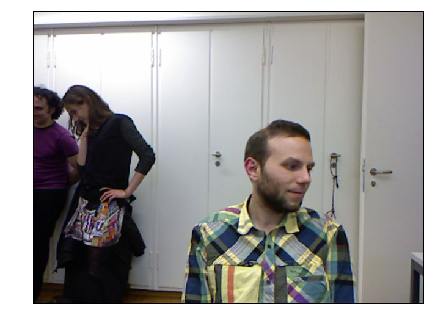

In [19]:
img = open_image(fname)
img.show(figsize=(7, 7))

In [24]:
def img2txt_name(f):
    return Path(f'{str(f)[:-7]}pose.txt')

In [25]:
fname, img2txt_name(fname)

(PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00667_rgb.jpg'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00667_pose.txt'))

In [26]:
! cat {img2txt_name(fname)}

0.804344 -0.193884 -0.56164 
0.145617 0.98076 -0.130024 
0.576043 0.0227998 0.817101 

187.332 40.3892 893.135 



In [28]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3)

In [50]:
ctr

array([187.332 ,  40.3892, 893.135 ])

In [66]:
def convert_biwi(coords):
    c = coords[:2] * np.diag(cal[:2, :2]) / coords[2] + cal[:2, 2]
    return tensor(list(reversed(list(c))))

def get_ctr(f):
    coords = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(coords)

def get_ip(img, pts):
    return ImagePoints(FlowField(img.size, pts), scale=True)

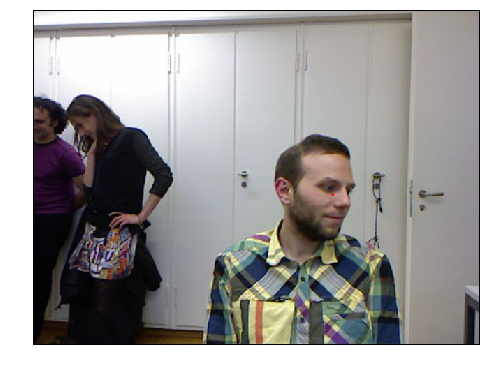

In [68]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(8, 8))

In [69]:
path

PosixPath('/home/jupyter/.fastai/data/biwi_head_pose')

In [78]:
src = (PointsItemList.from_folder(path)
 .split_by_valid_func(lambda o: o.parent.name == '13')
 .label_from_func(get_ctr))

In [79]:
size = (120, 160)

In [81]:
data = (src.transform(tfms=get_transforms(), tfm_y=True, size=size)
       .databunch()
       .normalize(imagenet_stats))

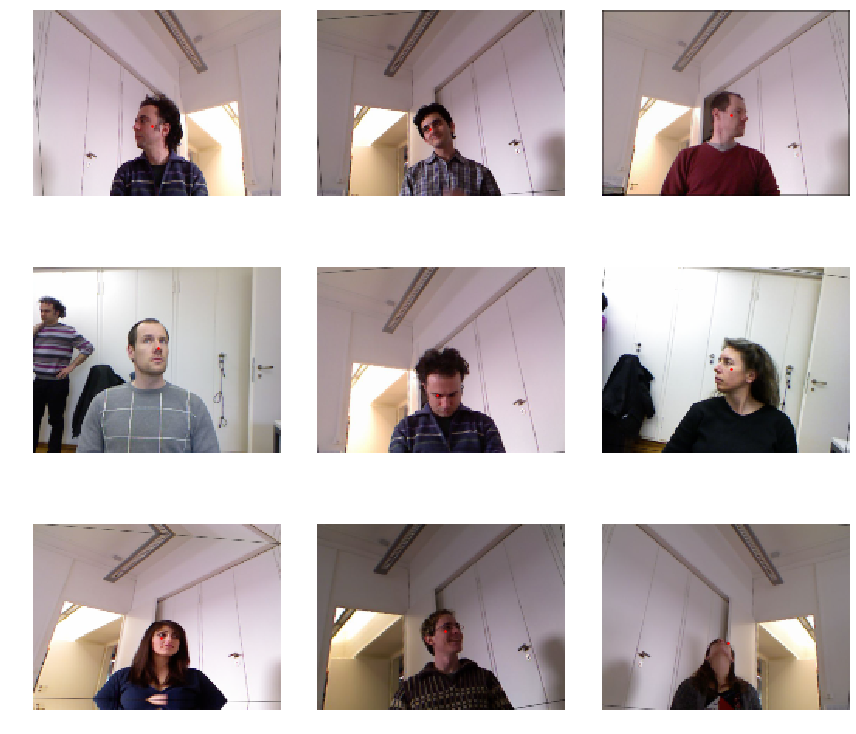

In [86]:
data.show_batch(rows=3, figsize=(12, 11))

In [87]:
learn = create_cnn(data, models.resnet34)

In [88]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


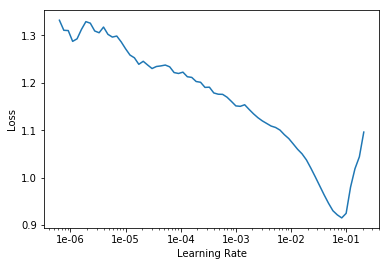

In [89]:
learn.recorder.plot()

In [90]:
max_lr = 1e-2

In [91]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(max_lr))

epoch,train_loss,valid_loss
1,0.062147,0.003244
2,0.024180,0.003176
3,0.011853,0.001345
4,0.007300,0.001636
5,0.005421,0.001205


In [92]:
learn.save('stage-1')

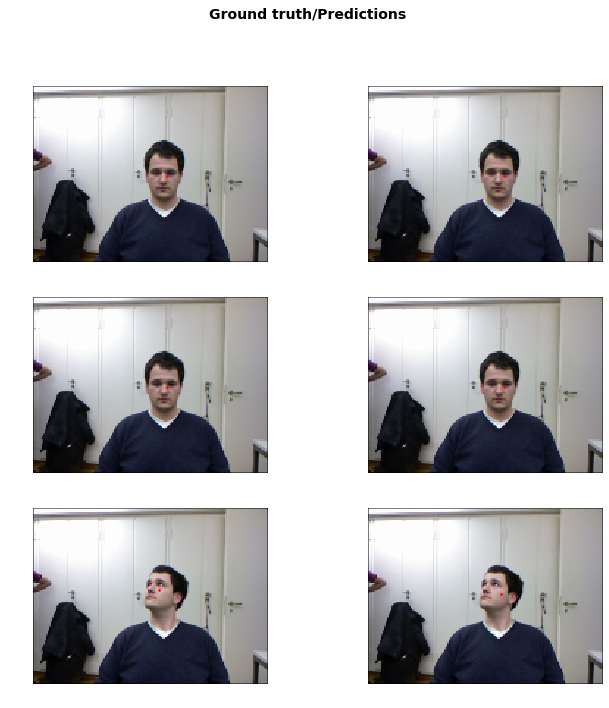

In [93]:
learn.show_results(rows=3, figsize=(11, 11))

In [95]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=.5, max_warp=.4, p_affine=1., p_lighting=1.)



In [144]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name == '13')
        .label_from_func(get_ctr)
        .transform(tfms=tfms, size=size, tfm_y=True)
        .databunch()
        .normalize(imagenet_stats))

In [145]:
def _plot(i, j, ax):
    x, y = data.train_ds[0]
    x.show(ax, y=y)

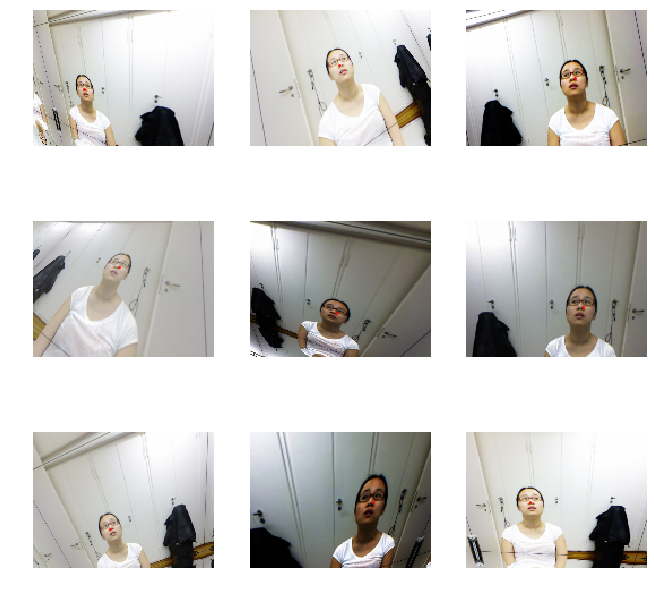

In [146]:
plot_multi(_plot, r=3, c=3, figsize=(11, 11))